In [ ]:
import pandas as pd
import numpy as np
import io
import sys
import os
import urllib.request
from tqdm import tqdm
from os import listdir
from PIL import Image
import glob

from Levenshtein import distance as levenshtein_dist
import cv2  #pip install opencv-python
import matplotlib.pyplot as plt

# Configure pandas and numpy settings for better output display
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=sys.maxsize)

In [2]:
df = pd.read_csv("MovieGenre.csv",encoding='ISO-8859-1')
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,"https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg"
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,"https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg"
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BMTczMTMyMTgyM15BMl5BanBnXkFtZTcwOTc4OTQyMQ@@._V1_UY268_CR4,0,182,268_AL_.jpg"
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,"https://images-na.ssl-images-amazon.com/images/M/MV5BOTEyNzg5NjYtNDU4OS00MWYxLWJhMTItYWU4NTkyNDBmM2Y0XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg"


In [3]:
# Drop rows with missing values
df = df.dropna(axis=0, how='any')

# Retain only the last 300 rows for processing
df = df.iloc[-300:]

# Display the shape of the resulting DataFrame
df.shape


(300, 6)

In [4]:
# Method to download images from URLs
missing_posters = []
poster_ids = []

for idx, record in tqdm(df.iterrows()):

    image_url = record['Poster']
    movie_id = record['imdbId']

    save_path = "Posters/" + str(movie_id) + ".jpg"

    try:
        response = urllib.request.urlopen(image_url)
        image_data = response.read()
        with open(save_path, 'wb') as image_file:
            image_file.write(bytearray(image_data))
        poster_ids.append(str(movie_id))
    except:
        missing_posters.append(movie_id)

print("Total number of posters not downloaded: ", len(missing_posters))
print("List of missing IMDB IDs: ", missing_posters)


0it [00:00, ?it/s]

300it [00:39,  7.53it/s]

Total number of posters not downloaded:  20
List of missing IMDB IDs:  [58101, 76582, 111199, 4434688, 5673202, 5692030, 2596918, 491603, 3000844, 5317546, 37709, 3922798, 92519, 54826, 42830, 29786, 67576, 93991, 88757, 83168]


In [14]:
# Load the query image (the image we want to compare others against)
query_image_pil = Image.open('Posters/23277.jpg')  # Open the query image using PIL - insert the name of the image with the right extension
query_image_cv = cv2.imread('Posters/23277.jpg')  # Open the same query image using OpenCV for histogram analysis - insert the name of the image with the right extension

# Initialize a list to store similarity scores
similarity_scores = []

# Iterate over all poster IDs in the dataset to compare each image with the query image
for poster_id in poster_ids:  
    # Load the current comparison image using both PIL and OpenCV
    comparison_image_pil = Image.open(f'Posters/{poster_id}.jpg')
    comparison_image_cv = cv2.imread(f'Posters/{poster_id}.jpg')

    print(query_image_pil.filename)
    print(comparison_image_pil.filename)

    # Ensure that we are not comparing the query image with itself
    if comparison_image_pil != query_image_pil:

        # Step 1: Text Comparison
        query_text = pytesseract.image_to_string(query_image_pil)  # Extract text from the query image
        comparison_text = pytesseract.image_to_string(comparison_image_pil)  # Extract text from the comparison image

        # Split extracted text into words for comparison
        query_words = tuple(query_text.split())
        comparison_words = tuple(comparison_text.split())

        # Calculate Levenshtein distance between words from both images
        total_distance = 0
        for word_query in query_words:
            for word_comp in comparison_words:
                total_distance += levenshtein_dist(word_query, word_comp)

        # Compute mean text similarity score
        if len(query_words) == 0 or len(comparison_words) == 0:
            mean_text_similarity = 0  # Handle cases where no text is extracted
        else:
            mean_text_similarity = total_distance / (len(query_words) * len(comparison_words))

        # Step 2: Color Histogram Comparison
        blue_hist_query = cv2.calcHist([query_image_cv], [0], None, [256], [0, 256])
        green_hist_query = cv2.calcHist([query_image_cv], [1], None, [256], [0, 256])
        red_hist_query = cv2.calcHist([query_image_cv], [2], None, [256], [0, 256])

        blue_hist_comp = cv2.calcHist([comparison_image_cv], [0], None, [256], [0, 256])
        green_hist_comp = cv2.calcHist([comparison_image_cv], [1], None, [256], [0, 256])
        red_hist_comp = cv2.calcHist([comparison_image_cv], [2], None, [256], [0, 256])

        # Compare histograms using correlation metric (how well they match)
        corr_blue = cv2.compareHist(blue_hist_query, blue_hist_comp, cv2.HISTCMP_CORREL)
        corr_green = cv2.compareHist(green_hist_query, green_hist_comp, cv2.HISTCMP_CORREL)
        corr_red = cv2.compareHist(red_hist_query, red_hist_comp, cv2.HISTCMP_CORREL)
        mean_correlation = (corr_blue + corr_green + corr_red) / 3

        # Compare histograms using intersection metric (overlap between histograms)
        intersect_blue = cv2.compareHist(blue_hist_query, blue_hist_comp, cv2.HISTCMP_INTERSECT)
        intersect_green = cv2.compareHist(green_hist_query, green_hist_comp, cv2.HISTCMP_INTERSECT)
        intersect_red = cv2.compareHist(red_hist_query, red_hist_comp, cv2.HISTCMP_INTERSECT)
        mean_intersection = (intersect_blue + intersect_green + intersect_red) / 3

        # Step 3: Compute Final Similarity Score       
        final_similarity_score = (
            0.3 * mean_text_similarity + 
            0.5 * mean_correlation + 
            0.2 * mean_intersection
        )

        # Append the final score and poster ID to the results list
        similarity_scores.append((final_similarity_score, poster_id))


C:\Users\25fad\OneDrive - Universidad Politécnica de Madrid\Msc\2nd semester\InfromationRetrieval\Report\2ND ASSIGNMENT - NON_TEXTUAL DATA EXTRACTION\Posters\23277.jpg
C:\Users\25fad\OneDrive - Universidad Politécnica de Madrid\Msc\2nd semester\InfromationRetrieval\Report\2ND ASSIGNMENT - NON_TEXTUAL DATA EXTRACTION\Posters\452664.jpg
C:\Users\25fad\OneDrive - Universidad Politécnica de Madrid\Msc\2nd semester\InfromationRetrieval\Report\2ND ASSIGNMENT - NON_TEXTUAL DATA EXTRACTION\Posters\23277.jpg
C:\Users\25fad\OneDrive - Universidad Politécnica de Madrid\Msc\2nd semester\InfromationRetrieval\Report\2ND ASSIGNMENT - NON_TEXTUAL DATA EXTRACTION\Posters\2296709.jpg
C:\Users\25fad\OneDrive - Universidad Politécnica de Madrid\Msc\2nd semester\InfromationRetrieval\Report\2ND ASSIGNMENT - NON_TEXTUAL DATA EXTRACTION\Posters\23277.jpg
C:\Users\25fad\OneDrive - Universidad Politécnica de Madrid\Msc\2nd semester\InfromationRetrieval\Report\2ND ASSIGNMENT - NON_TEXTUAL DATA EXTRACTION\Posters

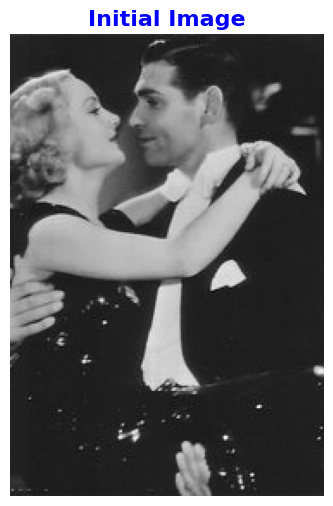

In [15]:
# Combine similarity scores with their corresponding poster IDs
unsorted_results = list(zip(similarity_scores, poster_ids))

# Sort the results in descending order based on similarity scores
sorted_results = sorted(unsorted_results, reverse=True)

# Display the query image (initial image)
plt.figure(figsize=(6, 6))
plt.imshow(query_image_pil)  # Show the query image
plt.title("Initial Image", fontsize=16, fontweight='bold', color='blue')
plt.axis("off")
plt.show()  # Display the plot

Top 5 Similar Posters:
Rank 1: Poster ID = 24676, Similarity Score = 5737.07
Rank 2: Poster ID = 62096, Similarity Score = 5339.50
Rank 3: Poster ID = 1332023, Similarity Score = 5205.24
Rank 4: Poster ID = 4487148, Similarity Score = 5013.33
Rank 5: Poster ID = 4882174, Similarity Score = 4975.96


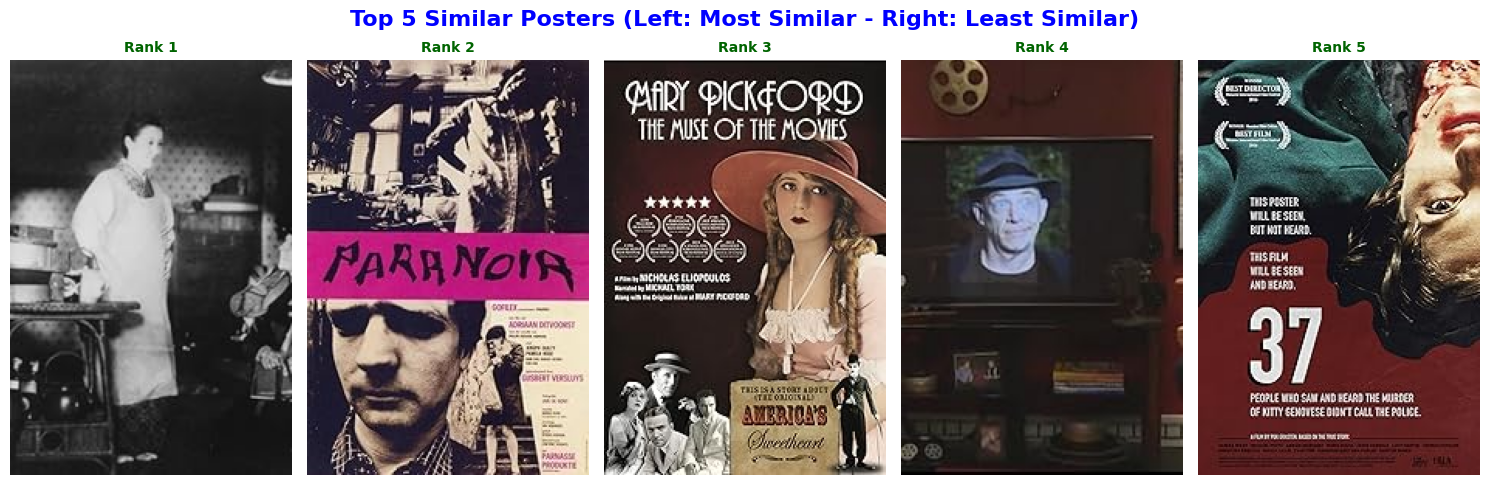

In [16]:
# Print the top 5 similarity scores and their corresponding poster IDs
print("Top 5 Similar Posters:")
for position in range(5):
    similarity_score = sorted_results[position][0][0]  # Extract the numeric similarity score
    poster_id = sorted_results[position][1]  # Extract the poster ID
    print(f"Rank {position + 1}: Poster ID = {poster_id}, Similarity Score = {similarity_score:.2f}")

# Plot the top 5 most similar images side by side with enhanced design
plt.figure(figsize=(15, 5))

# Create subplots for each of the top 5 images
for idx in range(5):
    plt.subplot(1, 5, idx + 1)
    plt.axis("off")
    
    # Load and display the current image
    image_to_plot = Image.open(f"Posters/{sorted_results[idx][1]}.jpg")
    plt.imshow(image_to_plot)
    
    # Add a title to each subplot indicating its rank
    plt.title(f"Rank {idx + 1}", fontsize=10, fontweight='bold', color='darkgreen')

# Add a main title to indicate similarity ranking
plt.suptitle("Top 5 Similar Posters (Left: Most Similar - Right: Least Similar)", 
             fontsize=16, fontweight='bold', color='blue')
plt.tight_layout()
plt.show()